# DEVELOPING CHATBOT TO RESPOND ON COMPANY POLICY (RAG WITH HUGGING FACE)

In [1]:
!pip install --user transformers datasets torch faiss-cpu wget

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 141.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.0/821.0 MB ? eta 0:00:00 0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 19.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 41.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 48.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 29.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 51.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 48.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━

In [2]:
!pip install --user matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 119.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 126.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 123.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 132.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 167.1 MB/s eta 0:00:0000:01


## Importing required libraries
It is recommended that you import all required libraries in one place (here):_


In [1]:
import wget
from transformers import DPRContextEncoder, DPRContextEncoderTokenizer
import torch

import numpy as np
import random
from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import numpy as np

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# Defining helper functions


In [2]:
def tsne_plot(data):
    # Apply t-SNE to reduce to 3D
    tsne = TSNE(n_components=3, random_state=42,perplexity=data.shape[0]-1)
    data_3d = tsne.fit_transform(data)
    
    # Plotting
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Assign colors for each point based on its index
    num_points = len(data_3d)
    colors = plt.cm.tab20(np.linspace(0, 1, num_points))
    
    # Plot scatter with unique colors for each point
    for idx, point in enumerate(data_3d):
        ax.scatter(point[0], point[1], point[2], label=str(idx), color=colors[idx])
    
    # Adding labels and titles
    ax.set_xlabel('TSNE Component 1')
    ax.set_ylabel('TSNE Component 2')
    ax.set_zlabel('TSNE Component 3')
    plt.title('3D t-SNE Visualization')
    plt.legend(title='Input Order')
    plt.show()

In [3]:
filename = 'companyPolicies.txt'
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/6JDbUb_L3egv_eOkouY71A.txt'

# Use wget to download the file
wget.download(url, out=filename)
print('file downloaded')

file downloaded


## Reading and preprocessing the data



In [4]:
def read_and_split_text(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        text = file.read()
    # Split the text into paragraphs (simple split by newline characters)
    paragraphs = text.split('\n')
    # Filter out any empty paragraphs or undesired entries
    paragraphs = [para.strip() for para in paragraphs if len(para.strip()) > 0]
    return paragraphs

# Read the text file and split it into paragraphs
paragraphs = read_and_split_text('companyPolicies.txt')
paragraphs[0:10]

['1.\tCode of Conduct',
 'Our Code of Conduct outlines the fundamental principles and ethical standards that guide every member of our organization. We are committed to maintaining a workplace that is built on integrity, respect, and accountability.',
 'Integrity: We hold ourselves to the highest ethical standards. This means acting honestly and transparently in all our interactions, whether with colleagues, clients, or the broader community. We respect and protect sensitive information, and we avoid conflicts of interest.',
 "Respect: We embrace diversity and value each individual's contributions. Discrimination, harassment, or any form of disrespectful behavior is unacceptable. We create an inclusive environment where differences are celebrated and everyone is treated with dignity and courtesy.",
 'Accountability: We take responsibility for our actions and decisions. We follow all relevant laws and regulations, and we strive to continuously improve our practices. We report any potent

Lets look at the first few samples from the file:


In [5]:
for i in range(4):
    print(f"sample: {i} paragraph: {paragraphs[i]} \n" )

sample: 0 paragraph: 1.	Code of Conduct 

sample: 1 paragraph: Our Code of Conduct outlines the fundamental principles and ethical standards that guide every member of our organization. We are committed to maintaining a workplace that is built on integrity, respect, and accountability. 

sample: 2 paragraph: Integrity: We hold ourselves to the highest ethical standards. This means acting honestly and transparently in all our interactions, whether with colleagues, clients, or the broader community. We respect and protect sensitive information, and we avoid conflicts of interest. 

sample: 3 paragraph: Respect: We embrace diversity and value each individual's contributions. Discrimination, harassment, or any form of disrespectful behavior is unacceptable. We create an inclusive environment where differences are celebrated and everyone is treated with dignity and courtesy. 



# Building the retriever: Encoding and indexing

## Encoding texts into embeddings



In [6]:
%%capture
context_tokenizer = DPRContextEncoderTokenizer.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')
context_tokenizer

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizer'.


Please ignore the warnings above as they will be handled automatically.

Let's use this sample as it is simpler to relate the output back to BERT.


In [7]:
text = [("How are you?", "I am fine."), ("What's up?", "Not much.")]
print(text)

[('How are you?', 'I am fine.'), ("What's up?", 'Not much.')]


You can view the token indexes. Let's apply it to the text.


In [8]:
tokens_info=context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
tokens_info

{'input_ids': tensor([[ 101, 2129, 2024, 2017, 1029,  102, 1045, 2572, 2986, 1012,  102],
        [ 101, 2054, 1005, 1055, 2039, 1029,  102, 2025, 2172, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

- `token_type_ids`: These are segment embeddings used to distinguish different sentences or segments within the input. This is particularly useful in tasks that involve multiple types of input, such as question answering, where questions and context may need to be differentiated.

- `attention_mask`: The attention mask indicates which tokens should be attended to by the model. It has a value of 1 for actual tokens in the input sentences and 0 for padding tokens, ensuring that the model focuses only on meaningful data.

-  `input_ids`: These represent the indices of tokens in the tokenizer's vocabulary. To translate these indices back into readable tokens, you can use the method `convert_ids_to_tokens` provided by the tokenizer. Here's an example of how to use this method:


In [9]:
for s in tokens_info['input_ids']:
   print(context_tokenizer.convert_ids_to_tokens(s))

['[CLS]', 'how', 'are', 'you', '?', '[SEP]', 'i', 'am', 'fine', '.', '[SEP]']
['[CLS]', 'what', "'", 's', 'up', '?', '[SEP]', 'not', 'much', '.', '[SEP]']


In [10]:
context_encoder = DPRContextEncoder.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [11]:
#shuffling samples so that the samples are not ordered based on the category they belong to
random.shuffle(paragraphs)

In [12]:
tokens=context_tokenizer( paragraphs[:20], return_tensors='pt', padding=True, truncation=True, max_length=256) 
tokens
outputs=context_encoder(**tokens)
outputs.pooler_output

tensor([[ 0.1947, -0.1456,  0.1621,  ...,  0.0998,  0.1219,  0.4370],
        [-0.1626,  0.0201,  0.3065,  ..., -0.3258, -0.6221,  0.0723],
        [ 0.4441,  0.3670, -0.0401,  ..., -0.3736, -0.1618, -0.1306],
        ...,
        [ 0.4388,  0.1187,  0.0776,  ..., -0.4157, -0.5836, -0.0713],
        [ 0.9915,  0.4669, -0.0584,  ..., -0.1972, -0.3929, -0.0108],
        [ 0.1054,  0.0770, -0.0520,  ..., -0.5137, -0.6541, -0.0235]],
       grad_fn=<SliceBackward0>)

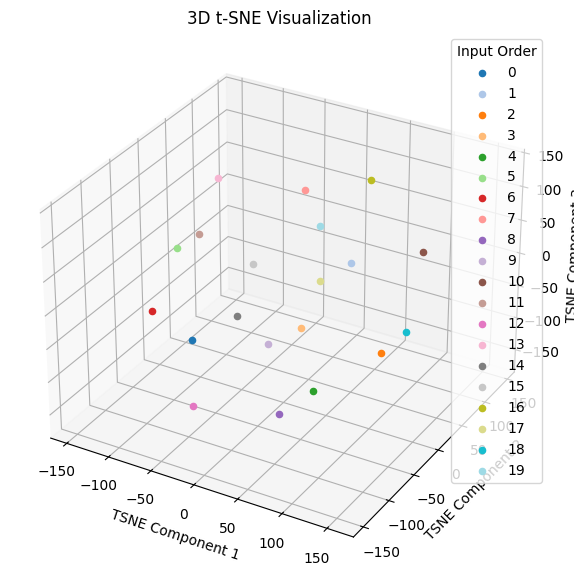

In [13]:
tsne_plot(outputs.pooler_output.detach().numpy())

Samples 16 and 12 are closer to each other on the graph shown above. Let's view the corresponding paragraphs:


In [14]:
print("sample 16:", paragraphs[16])

sample 16: Reporting: Employees should report any concerns related to drug or alcohol misuse by themselves or their colleagues, as well as safety concerns arising from such misuse.


In [15]:
print("sample 12:", paragraphs[12])

sample 12: Respect: We embrace diversity and value each individual's contributions. Discrimination, harassment, or any form of disrespectful behavior is unacceptable. We create an inclusive environment where differences are celebrated and everyone is treated with dignity and courtesy.


In [16]:
embeddings=[]
for text in paragraphs[0:5]:
    inputs = context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
    outputs = context_encoder(**inputs)
    embeddings.append(outputs.pooler_output)
    print("number of samples:")
    print(len(embeddings))
    print(" samples shape:")
    print(outputs.pooler_output.shape)

number of samples:
1
 samples shape:
torch.Size([1, 768])
number of samples:
2
 samples shape:
torch.Size([1, 768])
number of samples:
3
 samples shape:
torch.Size([1, 768])
number of samples:
4
 samples shape:
torch.Size([1, 768])
number of samples:
5
 samples shape:
torch.Size([1, 768])


In [17]:
torch.cat(embeddings).detach().numpy().shape

(5, 768)

Now, let's consolidate all the steps into a function:


In [18]:
def encode_contexts(text_list):
    # Encode a list of texts into embeddings
    embeddings = []
    for text in text_list:
        inputs = context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
        outputs = context_encoder(**inputs)
        embeddings.append(outputs.pooler_output)
    return torch.cat(embeddings).detach().numpy()

# you would now encode these paragraphs to create embeddings.
context_embeddings = encode_contexts(paragraphs)

## Creating and populating the FAISS index



In [19]:
import faiss

# Convert list of numpy arrays into a single numpy array
embedding_dim = 768  # This should match the dimension of your embeddings
context_embeddings_np = np.array(context_embeddings).astype('float32')

# Create a FAISS index for the embeddings
index = faiss.IndexFlatL2(embedding_dim)
index.add(context_embeddings_np)  # Add the context embeddings to the index

In [20]:
# Load DPR question encoder and tokenizer
question_encoder = DPRQuestionEncoder.from_pretrained('facebook/dpr-question_encoder-single-nq-base')
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained('facebook/dpr-question_encoder-single-nq-base')

config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Please ignore the warnings above as they will be handled automatically.


In [21]:
# Example question
question = 'Drug and Alcohol Policy'
question_inputs = question_tokenizer(question, return_tensors='pt')
question_embedding = question_encoder(**question_inputs).pooler_output.detach().numpy()

# Search the index
D, I = index.search(question_embedding, k=5)  # Retrieve top 5 relevant contexts
print("D:",D)
print("I:",I)

D: [[72.765305 74.71617  84.3881   88.364365 90.287094]]
I: [[32  7 40 15 21]]


You can print out Top 5 relevant contexts and their distance:


In [22]:
print("Top 5 relevant contexts:")
for i, idx in enumerate(I[0]):
    print(f"{i+1}: {paragraphs[idx]}")
    print(f"distance {D[0][i]}\n")

Top 5 relevant contexts:
1: 6.	Drug and Alcohol Policy
distance 72.76530456542969

2: Policy Objective: The Drug and Alcohol Policy is established to establish clear expectations and guidelines for the responsible use of drugs and alcohol within the organization. This policy aims to maintain a safe, healthy, and productive workplace.
distance 74.71617126464844

3: Testing and Searches: The organization reserves the right to conduct drug and alcohol testing as per applicable laws and regulations. Employees may be subject to testing in cases of reasonable suspicion, post-accident, or as part of routine workplace safety measures.
distance 84.38809967041016

4: 9.	Discipline and Termination Policy
distance 88.36436462402344

5: Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes.
distance 90.28709411621094



Let's convert the above to a function:


In [23]:
def search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5):
    """
    Searches for the most relevant contexts to a given question.

    Returns:
    tuple: Distances and indices of the top k relevant contexts.
    """
    # Tokenize the question
    question_inputs = question_tokenizer(question, return_tensors='pt')

    # Encode the question to get the embedding
    question_embedding = question_encoder(**question_inputs).pooler_output.detach().numpy()

    # Search the index to retrieve top k relevant contexts
    D, I = index.search(question_embedding, k)

    return D, I

# Enhancing response generation with LLMs

After the retrieval component selects relevant documents or passages, the Large Language Model (LLM) integrates this information with its extensive pretrained knowledge to construct coherent and contextually relevant answers. This process leverages the LLM's ability to understand and manipulate language based on the specific inputs provided by the retrieval phase, enabling the generation of precise answers to complex questions.

### Loading models and tokenizers

Before utilizing word embeddings, you must load an LLM to generate text. Currently, the LLM lacks specific knowledge of your dataset or task, but it possesses general knowledge.

In this part of the lab, you will load essential models and their corresponding tokenizers that are pivotal for generating answers and encoding questions. This setup involves components from the Hugging Face Transformers library, renowned for its comprehensive collection of pretrained models.

### GPT2 model and tokenizer

GPT2 (Bidirectional and Auto-Regressive Transformers) is a powerful sequence-to-sequence model known for its effectiveness in text generation tasks:

- **Model**: The GPT2 model, specifically configured for conditional text generation, excels in generating answers based on the context provided by the retrieval system. Its architecture supports complex, context-driven text generation tasks, making it ideal for applications like question answering, where nuanced and detailed responses are required.

- **Tokenizer**: The corresponding tokenizer for GPT2 is crucial for preprocessing text inputs to be suitable for the model. It handles:
  - **Tokenization**: Breaking down text into tokens that the model can process.
  - **Token IDs conversion**: Transforming tokens into numerical identifiers that the model can understand.
  - **Padding and truncation**: Ensuring that all input sequences are of uniform length, either by padding shorter texts or truncating longer ones to a specified maximum length.
 
By integrating these models and tokenizers, the system is equipped to handle two critical tasks essential for effective question answering:
- **Encoding user queries**: Utilizing the DPR question encoder and its tokenizer, user queries are transformed into a form that efficiently retrieves related information.
- **Generating relevant answers**: The GPT2 model takes the retrieved information to generate responses that are not only relevant but also contextually rich.

This combination of GPT2 for generation and DPR for question encoding creates a robust framework for your natural language processing application, enabling it to deliver accurate and context-aware responses to user inquiries.


In [24]:
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")
model.generation_config.pad_token_id = tokenizer.pad_token_id

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Input text: 


In [25]:
contexts= "What is a large language model?"

Tokenize the input text to prepare it for the model:


In [26]:
inputs = tokenizer(contexts, return_tensors='pt', max_length=1024, truncation=True)
print(inputs)

{'input_ids': tensor([[2061,  318,  257, 1588, 3303, 2746,   30]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}


Utilize the LLM to generate text, ensuring that the output is in token indexes:


In [27]:
summary_ids = model.generate(inputs['input_ids'], max_length=50, num_beams=4, early_stopping=True,
                             pad_token_id=tokenizer.eos_token_id)
summary_ids

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


tensor([[ 2061,   318,   257,  1588,  3303,  2746,    30,   198,   198,    32,
          1588,  3303,  2746,   318,   257,   900,   286,  3173,   326,  6901,
           703,   257,  3303,   815, 17438,   287,   257,  1813,  4732,    13,
           198,   198,    32,  1588,  3303,  2746,   318,   257,   900,   286,
          3173,   326,  6901,   703,   257,  3303,   815, 17438,   287,   257]])

Please ignore the warnings above as they will be handled automatically.

Decode the generated token indexes back to text:


In [28]:
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print(summary)

What is a large language model?

A large language model is a set of rules that describe how a language should behave in a given context.

A large language model is a set of rules that describe how a language should behave in a


## Comparing answer generation: With and without DPR contexts

In this section of the lab, you will explore how the integration of retrieval contexts from DPR affects the quality of answers generated by the GPT2 model. This comparison will help illustrate the impact of contextual information on the accuracy and relevance of the answers. The ```generate_answer``` is almost identical; it just joins the retrieved contexts from <b>Query and Context Retrieval</b>.


### Generating answers directly from questions

First, let's look at how the GPT2 model generates answers without any additional context:


In [29]:
def generate_answer_without_context(question):
    # Tokenize the input question
    inputs = tokenizer(question, return_tensors='pt', max_length=1024, truncation=True)
    
    # Generate output directly from the question without additional context
    summary_ids = model.generate(inputs['input_ids'], max_length=150, min_length=40, length_penalty=2.0,
                                 num_beams=4, early_stopping=True,pad_token_id=tokenizer.eos_token_id)
    
    # Decode and return the generated text
    answer = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return answer

In [30]:
# Example usage
question = "what is mobile policy?"
answer = generate_answer_without_context(question)

print("Answer:", answer)

Answer: what is mobile policy?

Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other


### Generating answers with DPR contexts
Next, let's demonstrate how answers are generated when the model utilizes contexts retrieved via DPR, which are expected to enhance the answer's relevance and depth:


In [31]:
def generate_answer(question, contexts):
    # Concatenate the retrieved contexts to form the input to GPT2
    input_text = question + ' ' + ' '.join(contexts)
    inputs = tokenizer(input_text, return_tensors='pt', max_length=1024, truncation=True)

    # Generate output using GPT2
    summary_ids = model.generate(inputs['input_ids'], max_new_tokens=50, min_length=40, length_penalty=2.0,
                                 num_beams=4, early_stopping=True,pad_token_id=tokenizer.eos_token_id)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [32]:
question = "what is mobile policy?"

_,I =search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5)

print(f"paragraphs indexs {I}")

paragraphs indexs [[24 50 21 20 30]]


The top paragraphs from the query and context retrieval are show here:


In [33]:
top_contexts = [paragraphs[idx] for idx in I[0]] 
print(f"top_contexts {top_contexts}")

top_contexts ['4.\tMobile Phone Policy', 'The Mobile Phone Policy sets forth the standards and expectations governing the appropriate and responsible usage of mobile devices in the organization. The purpose of this policy is to ensure that employees utilize mobile phones in a manner consistent with company values and legal compliance.', 'Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes.', 'Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations.', 'The Mobile Phone Policy is aimed at promoting the responsible and secure use of mobile devices in line with legal and ethical standards. Every employee is expected to comprehend and abide by these guidelines. Regular reviews of the policy ensure its ongoing alignment with evolving technology and security best practices.']


You can input the response from the model.


In [ ]:
# Assume `I[0]` contains indices of top contexts from the retrieval step
answer = generate_answer(question, top_contexts)
print("Generated Answer:", answer)

## Observations and results

After experimenting with generating answers using GPT2 both directly and with the augmentation of DPR contexts, you can observe significant differences in the quality and relevance of the generated answers:
- **Direct generation**:
  - Without DPR contexts, GPT2 relies solely on its pretrained knowledge to infer answers. This approach can sometimes lead to less precise or overly generic responses, as the model lacks specific information related to the query.
- **Generation with DPR contexts**:
  - Incorporating DPR allows GPT2 to access specific information relevant to the query. This significantly enhances the accuracy and details of the generated answers, providing more informed and contextually appropriate responses.

The comparison clearly shows that integrating DPR retrieval with generative models such as GPT2 leads to more effective and contextually relevant answers. This demonstrates the effectiveness of combining retrieval and generation techniques in natural language processing applications, where the context provided by DPR can greatly improve the quality of the generated content.
